In [276]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency, ttest_ind, spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

In [277]:
df = pd.read_csv("../Dataset/full_merged_data_70k_unique_final.csv")
df.columns

/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_25680/4095757797.py:1: DtypeWarning: Columns (19,45,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Dataset/full_merged_data_70k_unique_final.csv")


Index(['package_name', 'description', 'package_maintainers',
       'readmeFilename_exists', 'package_created', 'package_modified',
       'package_age_months', 'num_of_versions', 'latest_version',
       'dependencies_list', 'dependencies_count', 'devdependencies_list',
       'devdependencies_count', 'last_month_downloads',
       'last_3_month_downloads', 'months_since_latest_version_release',
       'version_release_frequency_months', 'version_release_frequency_years',
       'license', 'Health_score', 'Popularity', 'Maintainence', 'Community',
       'Security_recommendation', 'vulnerabilities_count', 'git_repository',
       'total_commits', 'git_unique_contributors', 'avg_commits_per_day',
       'last_commit_before_months', 'github_forks', 'github_stars', 'open_PRs',
       'merged_PRs', 'open_issues', 'resolved_issues', 'LOC',
       'total_lines_added', 'total_lines_deleted',
       'lines_added_one_and_half_year', 'lines_deleted_one_and_half_year',
       'readme_updated_las

In [278]:
nan_count = df['package_name'].isna().sum()
nan_count

0

In [279]:
df.dropna(subset=['package_name'], inplace=True)

In [280]:
nan_count = df['package_name'].isna().sum()
nan_count

0

In [281]:
len(df)

28037

In [282]:
df = df.rename(columns={'trivial': 'Trivial'})

In [283]:
df = df.rename(columns={'inactive': 'Inactive'})

In [284]:
df = df.rename(columns={'dead': 'Dead'})

In [285]:
df = df.rename(columns={'deprecated': 'Deprecated'})

# RQ1

In [286]:
number_of_trivial = df[df['Trivial'] == True].shape[0]
total = df['Trivial'].count()
print(f"Trivial percentage: {(number_of_trivial/total)*100} %")

Trivial percentage: 16.026372978746913 %


In [287]:
number_of_dead = df[df['Dead'] == True].shape[0]
total = df['Dead'].count()
print(f"Dead percentage: {(number_of_dead/total)*100} %")

Dead percentage: 73.66337339943647 %


In [288]:
number_of_inactive = df[df['Inactive'] == True].shape[0]
total = df['Inactive'].count()
print(f"Inactive percentage: {(number_of_inactive/total)*100} %")

Inactive percentage: 9.680065627563577 %


In [289]:
number_of_deprecated = df[df['Deprecated'] == True].shape[0]
total = df['Deprecated'].count()
print(f"'Deprecated' percentage: {(number_of_deprecated/total)*100} %")

'Deprecated' percentage: 3.320612048364661 %


In [290]:
categories = ['Trivial', 'Dead', 'Inactive', 'Deprecated']
def percentage_count(df):
    dict = {}
    for cat in categories:
        num = df[df[cat] == True].shape[0]
        total = df[cat].count()
        dict[cat] = (num/total)*100
    return dict

In [291]:
# Perform bootstrapping and sample data 10 times
np.random.seed(42)
bootstrapped_samples = [df.sample(n=len(df), replace =True) for _ in range(10)]

In [292]:
package_percentage = []
for sample in bootstrapped_samples:
    package_percentage.append(percentage_count(sample))

In [293]:
percentage_df = pd.DataFrame(package_percentage)
percentage_df

,Trivial,Dead,Inactive,Deprecated
0,16.326756,73.681207,9.319827,3.441880
1,16.023728,73.820309,9.341228,3.498948
2,15.950559,73.588472,9.915469,3.317045
3,16.055384,73.192567,9.872668,3.481114
4,16.392053,73.649107,9.540964,3.284945
5,15.734807,73.135500,9.701466,3.366979
6,16.168944,73.463637,9.858401,3.370546
7,15.712914,73.574206,9.754967,3.274245
8,15.731869,74.091379,9.715733,3.491814
9,15.936695,73.809609,9.765667,3.431180


In [294]:
mean_values = percentage_df.mean()

# Convert the mean values to a DataFrame with one row
mean_row = pd.DataFrame([mean_values], columns=percentage_df.columns)

# Append mean row to the end of the DataFrame
percentage_df = pd.concat([percentage_df, mean_row], ignore_index=True)
percentage_df

,Trivial,Dead,Inactive,Deprecated
0,16.326756,73.681207,9.319827,3.441880
1,16.023728,73.820309,9.341228,3.498948
2,15.950559,73.588472,9.915469,3.317045
3,16.055384,73.192567,9.872668,3.481114
4,16.392053,73.649107,9.540964,3.284945
5,15.734807,73.135500,9.701466,3.366979
6,16.168944,73.463637,9.858401,3.370546
7,15.712914,73.574206,9.754967,3.274245
8,15.731869,74.091379,9.715733,3.491814
9,15.936695,73.809609,9.765667,3.431180


# RQ2

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28037 entries, 0 to 28036
Data columns (total 52 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   package_name                         28037 non-null  object 
 1   description                          27515 non-null  object 
 2   package_maintainers                  28037 non-null  float64
 3   readmeFilename_exists                28037 non-null  bool   
 4   package_created                      28037 non-null  int64  
 5   package_modified                     28037 non-null  int64  
 6   package_age_months                   28037 non-null  float64
 7   num_of_versions                      28037 non-null  object 
 8   latest_version                       28037 non-null  object 
 9   dependencies_list                    28037 non-null  object 
 10  dependencies_count                   28037 non-null  float64
 11  devdependencies_list        

In [296]:
# to remove: package_name, latest_version, dependencies_name, dev_dependencies_name , git_repository, 'last_modified', package_created

In [297]:
df['#_of_files'].head()

0     0.0
1     3.0
2     0.0
3    12.0
4     0.0
Name: #_of_files, dtype: object

In [298]:
analysis_df = df.copy()

### !!!!!!! Discuss about last_modified, package created !!!!!!

In [299]:
columns_to_remove = ['package_name', 'latest_version', 'dependencies_list', 'devdependencies_list', 'git_repository', 'package_created']
analysis_df.drop(columns=columns_to_remove, inplace = True)

In [300]:
# Convert 'readme_exists_npmjs' column to boolean type
analysis_df['readmeFilename_exists'] = analysis_df['readmeFilename_exists'].astype(bool)
analysis_df['TS_Typings'] = analysis_df['TS_Typings'].astype(bool)

# Convert 'Health Score' column to numeric, replacing non-numeric values with NaN
analysis_df['Health_score'] = pd.to_numeric(analysis_df['Health_score'], errors='coerce')
analysis_df['num_of_versions'] = pd.to_numeric(analysis_df['num_of_versions'], errors='coerce')
analysis_df['#_of_files'] = pd.to_numeric(analysis_df['#_of_files'], errors='coerce')

# # Replace non-finite values (NaN) with a default value (e.g., 0)
# analysis_df['Health_score'].fillna(0, inplace=True)

# # Convert 'Health Score' column to integer data type
# analysis_df['Health_score'] = analysis_df['Health_score'].astype('int64')

# Insert True or False
analysis_df['license'] = analysis_df['license'].notna()
analysis_df['description'] = analysis_df['description'].notna()

In [301]:
def convert_to_kb(value):
    if isinstance(value, float):
        return value
    elif 'kB' in value:
        return float(value.replace(' kB', ''))
    elif 'MB' in value:
        return float(value.replace(' MB', '')) * 1024
    elif 'B' in value:
        return float(value.replace(' B', '')) / 1024
    else:
        return float(value)  # Assume value is in kilobytes

In [302]:
analysis_df['package_install_size'] = analysis_df['package_install_size'].apply(convert_to_kb)

In [303]:
post_df = analysis_df.copy()

In [304]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28037 entries, 0 to 28036
Data columns (total 46 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   description                          28037 non-null  bool   
 1   package_maintainers                  28037 non-null  float64
 2   readmeFilename_exists                28037 non-null  bool   
 3   package_modified                     28037 non-null  int64  
 4   package_age_months                   28037 non-null  float64
 5   num_of_versions                      28031 non-null  float64
 6   dependencies_count                   28037 non-null  float64
 7   devdependencies_count                28037 non-null  float64
 8   last_month_downloads                 28037 non-null  float64
 9   last_3_month_downloads               28037 non-null  float64
 10  months_since_latest_version_release  28037 non-null  float64
 11  version_release_frequency_mo

In [305]:
# Assuming 'df' is your DataFrame
categorical_variables = []

for column in analysis_df.iloc[:, :-4].columns:
    if analysis_df[column].dtype == 'object' or analysis_df[column].dtype == 'bool':
        categorical_variables.append(column)

In [306]:
categorical_variables

['description',
 'readmeFilename_exists',
 'license',
 'Popularity',
 'Maintainence',
 'Community',
 'Security_recommendation',
 'readme_updated_last_1.5_year',
 'TS_Typings']

In [307]:
def chi_test(analysis_df, y):
    significant_predictors = []
    for column in categorical_variables:
        crosstab = pd.crosstab(analysis_df[column], y)
        chi2, p_val, _, _ = chi2_contingency(crosstab)
        if p_val < 0.05:
            dict = {}
            dict['predictor'] = column
            dict['test_stat'] = chi2
            dict['p_val'] = p_val
            dict['from'] = "chi2"
            corr_coef = np.sqrt(chi2 / len(analysis_df))
            dict['corr'] = corr_coef
            significant_predictors.append(dict)
    return significant_predictors

In [308]:
# Function to calculate VIF for each predictor
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Predictor"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [309]:
cols_to_remove = analysis_df.select_dtypes(include=['float', 'int'])
cols_to_remove.fillna(cols_to_remove.mean(), inplace=True)
dropped_indices = cols_to_remove.index[cols_to_remove.isna().any(axis=1)].tolist()
cols_to_remove.dropna(inplace=True)


vif_scores = calculate_vif(cols_to_remove)


# Remove predictors with high VIF (indicating multicollinearity)
high_vif_predictors = vif_scores[vif_scores['VIF'] > 5]['Predictor'].tolist()
analysis_df = analysis_df.drop(high_vif_predictors, axis=1)

In [310]:
def numeric(analysis_df, y):
    numeric_df = analysis_df.select_dtypes(include=['float', 'int'])
    numeric_df.fillna(numeric_df.mean(), inplace=True)
    dropped_indices = numeric_df.index[numeric_df.isna().any(axis=1)].tolist()
    numeric_df.dropna(inplace=True)

    # # Calculate VIF for predictors to identify multicollinearity
    # vif_scores = calculate_vif(numeric_df)
    # # Remove predictors with high VIF (indicating multicollinearity)
    # high_vif_predictors = vif_scores[vif_scores['VIF'] > 10]['Predictor'].tolist()
    # numeric_df = numeric_df.drop(high_vif_predictors, axis=1)

    if len(dropped_indices) > 0:
        y = y[y.index != dropped_indices]
    return numeric_df, y

In [311]:
# def ttest(numeric_df, y):
#     significant_predictors = []
#     dropped_indices = y.index[y.isna()]
#     if len(dropped_indices) > 0:
#         y = y[~y.index.isin(dropped_indices)]  # Filter y using dropped_indices
#         numeric_df = numeric_df[~numeric_df.index.isin(dropped_indices)]  # Filter numeric_df using dropped_indices
#     for column in numeric_df.columns:
#         t_stat, p_val = ttest_ind(numeric_df[y == True][column], numeric_df[y == False][column], equal_var = False)
#         if p_val < 0.1:
#             result_dict = {}
#             spearman_corr, _ = spearmanr(numeric_df[column], y)
#             result_dict['predictor'] = column
#             result_dict['test_stat'] = t_stat
#             result_dict['p_val'] = p_val
#             result_dict['from'] = "ttest"
#             result_dict['corr'] = spearman_corr
#             significant_predictors.append(result_dict)
#     return significant_predictors

In [312]:
def mannwhitneyu_test(numeric_df, y):
    significant_predictors = []
    dropped_indices = y.index[y.isna()]
    if len(dropped_indices) > 0:
        y = y[~y.index.isin(dropped_indices)]  # Filter y using dropped_indices
        numeric_df = numeric_df[~numeric_df.index.isin(dropped_indices)]  # Filter numeric_df using dropped_indices
    for column in numeric_df.columns:
        u_stat, p_val = mannwhitneyu(numeric_df[y == True][column], numeric_df[y == False][column], alternative='two-sided')
        if p_val < 0.1:
            result_dict = {}
            spearman_corr, _ = spearmanr(numeric_df[column], y)
            result_dict['predictor'] = column
            result_dict['test_stat'] = u_stat
            result_dict['p_val'] = p_val
            result_dict['from'] = "Mann-Whitney U test"
            result_dict['corr'] = spearman_corr
            significant_predictors.append(result_dict)
    return significant_predictors


In [313]:
def corr_value(data_list, pred):
    for item in data_list:
        if item['predictor'] == pred:
            corr_value = item['corr']
            return corr_value

In [314]:
def pred_corr(bootstrapped_samples, category):
    key_to_extract = 'predictor'
    sustained_predictors = []
    corr_cal = {}
    
    
    for i, sample in enumerate(bootstrapped_samples):
        numeric_df, y = numeric(sample, sample[category])
        significant_predictors_num = mannwhitneyu_test(numeric_df, y)
        
        significant_predictors_cat = chi_test(sample, y)
    
        significant_predictors = significant_predictors_num + significant_predictors_cat
        # print(significant_predictors)
        extracted_values = [d[key_to_extract] for d in significant_predictors]
        if len(sustained_predictors) > 0:
            common_values = list(set(extracted_values).intersection(set(sustained_predictors)))
            sustained_predictors = common_values          
                    
        else:
            sustained_predictors.extend(extracted_values)

        selected_dicts = [d for d in significant_predictors if d.get('predictor') in sustained_predictors]

        for pred in selected_dicts:
            if pred['predictor'] in corr_cal:
                corr_cal[pred['predictor']] = corr_cal[pred['predictor']] + corr_value(selected_dicts, pred['predictor'])
            else:
                corr_cal[pred['predictor']] = corr_value(selected_dicts, pred['predictor'])

    return sustained_predictors, corr_cal

In [315]:
def package_pred(corr_cal, sustained_predictors):
    final_predictors = []
    for key in corr_cal:
        if key in sustained_predictors:
            corr_dict = {}
            corr_dict[key] = corr_cal[key]/10
            final_predictors.append(corr_dict)
    return final_predictors

In [316]:
# Perform bootstrapping and sample data 10 times
np.random.seed(42)
bootstrapped_samples = [analysis_df.sample(n=len(analysis_df), replace=True) for _ in range(10)]
category_pred = {}

categories = ['Trivial', 'Dead', 'Inactive', 'Deprecated']

for package_cat in tqdm(categories):
    sustained_predictors, corr_cal = pred_corr(bootstrapped_samples, package_cat)
    final_predictors = package_pred(corr_cal, sustained_predictors)
    category_pred[package_cat] = final_predictors


100%|█████████████████████████████████████████████| 4/4 [00:15<00:00,  3.90s/it]


In [317]:
def categorize_strength(corr):
    corr_abs = abs(corr)
    if corr_abs >= 0.5:
        return 'Strong'
    elif corr_abs >= 0.3:
        return 'Moderate'
    else:
        return 'Weak'

### Trivial

In [318]:
# Initialize an empty list to store dictionaries
result_dicts = []

# Iterate through the list of dictionaries
for d in category_pred['Trivial']:
    # Extract key and value from each dictionary
    for key, value in d.items():
        # Create a new dictionary with 'predictor' and 'corr' keys
        result_dict = {'predictor': key, 'corr': value}
        # Append the new dictionary to the result_dicts list
        result_dicts.append(result_dict)

# Create DataFrame from the list of dictionaries
trivial_df = pd.DataFrame(result_dicts)
trivial_df['strength'] = trivial_df['corr'].apply(categorize_strength)
trivial_df

,predictor,corr,strength
0,package_maintainers,-0.042768,Weak
1,num_of_versions,-0.162853,Weak
2,dependencies_count,-0.188213,Weak
3,devdependencies_count,-0.146131,Weak
4,vulnerabilities_count,-0.016008,Weak
5,total_commits,-0.101646,Weak
6,git_unique_contributors,-0.155796,Weak
7,avg_commits_per_day,0.085539,Weak
8,open_PRs,-0.107562,Weak
9,open_issues,-0.127396,Weak


In [319]:
filtered_pred_df = trivial_df[(trivial_df['strength'] == 'Strong') | (trivial_df['strength'] == 'Moderate')]
filtered_pred_df

,predictor,corr,strength
10,LOC,-0.488857,Moderate
11,SLOC_JS,-0.553186,Strong
12,CC,-0.465120,Moderate


### Dead

In [320]:
# Initialize an empty list to store dictionaries
result_dicts = []

# Iterate through the list of dictionaries
for d in category_pred['Dead']:
    # Extract key and value from each dictionary
    for key, value in d.items():
        # Create a new dictionary with 'predictor' and 'corr' keys
        result_dict = {'predictor': key, 'corr': value}
        # Append the new dictionary to the result_dicts list
        result_dicts.append(result_dict)

# Create DataFrame from the list of dictionaries
dead_df = pd.DataFrame(result_dicts)
dead_df['strength'] = dead_df['corr'].apply(categorize_strength)
dead_df

,predictor,corr,strength
0,package_maintainers,-0.067165,Weak
1,num_of_versions,-0.198507,Weak
2,dependencies_count,-0.054993,Weak
3,devdependencies_count,-0.150771,Weak
4,total_commits,-0.103100,Weak
5,git_unique_contributors,-0.260553,Weak
6,avg_commits_per_day,0.097889,Weak
7,open_PRs,-0.144669,Weak
8,open_issues,-0.185500,Weak
9,LOC,-0.090763,Weak


In [321]:
filtered_pred_df = dead_df[(dead_df['strength'] == 'Strong') | (dead_df['strength'] == 'Moderate')]
filtered_pred_df

,predictor,corr,strength
11,SLOC_TS,-0.386170,Moderate
13,package_install_size,-0.413831,Moderate
14,#_of_files,-0.413453,Moderate
17,Maintainence,0.356638,Moderate
20,readme_updated_last_1.5_year,0.584839,Strong


### Inactive

In [322]:
# Initialize an empty list to store dictionaries
result_dicts = []

# Iterate through the list of dictionaries
for d in category_pred['Inactive']:
    # Extract key and value from each dictionary
    for key, value in d.items():
        # Create a new dictionary with 'predictor' and 'corr' keys
        result_dict = {'predictor': key, 'corr': value}
        # Append the new dictionary to the result_dicts list
        result_dicts.append(result_dict)

# Create DataFrame from the list of dictionaries
inactive_df = pd.DataFrame(result_dicts)
inactive_df['strength'] = inactive_df['corr'].apply(categorize_strength)
inactive_df

,predictor,corr,strength
0,package_maintainers,0.033006,Weak
1,num_of_versions,0.019195,Weak
2,devdependencies_count,0.033212,Weak
3,git_unique_contributors,0.051010,Weak
4,avg_commits_per_day,-0.051847,Weak
5,open_PRs,0.027154,Weak
6,open_issues,0.047349,Weak
7,SLOC_JS,0.024197,Weak
8,CC,0.021478,Weak
9,package_install_size,-0.021823,Weak


In [323]:
# filtered_pred_df = trivial_df[(trivial_df['strength'] == 'Strong') | (trivial_df['strength'] == 'Moderate')]
# filtered_pred_df

### Deprecated

In [324]:
# Initialize an empty list to store dictionaries
result_dicts = []

# Iterate through the list of dictionaries
for d in category_pred['Deprecated']:
    # Extract key and value from each dictionary
    for key, value in d.items():
        # Create a new dictionary with 'predictor' and 'corr' keys
        result_dict = {'predictor': key, 'corr': value}
        # Append the new dictionary to the result_dicts list
        result_dicts.append(result_dict)

# Create DataFrame from the list of dictionaries
deprecated_df = pd.DataFrame(result_dicts)
deprecated_df['strength'] = deprecated_df['corr'].apply(categorize_strength)
deprecated_df

,predictor,corr,strength
0,package_maintainers,0.049465,Weak
1,num_of_versions,0.052376,Weak
2,total_commits,0.055177,Weak
3,git_unique_contributors,0.065283,Weak
4,avg_commits_per_day,-0.020726,Weak
5,open_PRs,0.030384,Weak
6,LOC,0.019856,Weak
7,SLOC_TS,0.027865,Weak
8,Maintainence,0.040568,Weak
9,Community,0.075103,Weak


In [325]:
# filtered_pred_df = trivial_df[(trivial_df['strength'] == 'Strong') | (trivial_df['strength'] == 'Moderate')]

# filtered_pred_df

# RQ3

### 3A

In [326]:
package_categories = ['Trivial', 'Dead', 'Deprecated', 'Inactive']

# Create pairs of elements ensuring the reverse pair is also present
pairs = [(package_categories[i], package_categories[j]) for i in range(len(package_categories)) for j in range(i+1, len(package_categories))] + \
        [(package_categories[j], package_categories[i]) for i in range(len(package_categories)) for j in range(i+1, len(package_categories))]

# Display pairs
print(pairs)

[('Trivial', 'Dead'), ('Trivial', 'Deprecated'), ('Trivial', 'Inactive'), ('Dead', 'Deprecated'), ('Dead', 'Inactive'), ('Deprecated', 'Inactive'), ('Dead', 'Trivial'), ('Deprecated', 'Trivial'), ('Inactive', 'Trivial'), ('Deprecated', 'Dead'), ('Inactive', 'Dead'), ('Inactive', 'Deprecated')]


In [327]:
pair_corr = {}
for pair in pairs:
    pair_0 = df[df[pair[0]] == True]
    left_count = pair_0[pair_0[pair[1]] == True]
    left_percent = len(left_count)/len(pair_0)

    pair_corr[pair] = left_percent*100

pair_corr

{('Trivial', 'Dead'): 76.30429786256033,
 ('Trivial', 'Deprecated'): 2.2293725580326362,
 ('Trivial', 'Inactive'): 8.641691565157435,
 ('Dead', 'Deprecated'): 3.3021837021255998,
 ('Dead', 'Inactive'): 9.76613567036266,
 ('Deprecated', 'Inactive'): 11.600429645542427,
 ('Dead', 'Trivial'): 16.075146467825498,
 ('Deprecated', 'Trivial'): 10.41890440386681,
 ('Inactive', 'Trivial'): 13.854089904200443,
 ('Deprecated', 'Dead'): 73.25456498388829,
 ('Inactive', 'Dead'): 74.31834929992631,
 ('Inactive', 'Deprecated'): 3.97936624907885}

#### Should I do bootstrapping here as well?

In [328]:
pair_predictors = {}

for pair in pair_corr:
    pair_0_df = analysis_df[analysis_df[pair[0]] == True]
    y = pair_0_df[pair[1]]
    pair_0_df = pair_0_df.iloc[:, :-4]
    pair_0_df[pair[1]] = y
    bootstrapped_samples = [pair_0_df.sample(n=len(pair_0_df), replace=True) for _ in range(10)]
    sustained_predictors, corr_cal = pred_corr(bootstrapped_samples, pair[1])
    final_predictors = package_pred(corr_cal, sustained_predictors)
    pair_predictors[pair] = final_predictors

In [329]:
for pair_pred in pair_predictors:
    print("======================================")
    print(f"{pair_pred} ---> {pair_corr[pair_pred]}")
    print("-----------------------------------------")
    for dictionary in pair_predictors[pair_pred]:
        for key, value in dictionary.items():
            print(f"{key} : {value}")

('Trivial', 'Dead') ---> 76.30429786256033
-----------------------------------------
num_of_versions : -0.23377957481199071
dependencies_count : -0.06304618947480527
devdependencies_count : -0.21228357505255357
git_unique_contributors : -0.21924777666798984
avg_commits_per_day : 0.1336436338605027
open_PRs : -0.07447768142236469
open_issues : -0.09967545519945382
SLOC_JS : 0.05946453353248604
SLOC_TS : -0.3913716058987221
CC : 0.20418969454311137
package_install_size : -0.4416281914360892
#_of_files : -0.4395971192468924
readmeFilename_exists : 0.09142369563225398
Popularity : 0.12404024959250104
Maintainence : 0.3120562319734626
Community : 0.17921250203693673
Security_recommendation : 0.09276709568088677
readme_updated_last_1.5_year : 0.5363830666512266
('Trivial', 'Deprecated') ---> 2.2293725580326362
-----------------------------------------
package_maintainers : 0.06850813701714073
git_unique_contributors : 0.06321688587037615
avg_commits_per_day : -0.07762702480187747
('Trivial',

### 3B

In [331]:
categories = ['Trivial', 'Dead', 'Inactive', 'Deprecated']
health_corr = {}

post_df['health_status'] = post_df['Health_score'].apply(lambda x: 'Unhealthy' if x < 42 else 'Healthy')


for cat in categories:
    l = {}
    count = len(post_df[(post_df[cat] == True) & (post_df['health_status'] == 'Unhealthy')])
    total = len(post_df[post_df[cat] == True])
    health_corr[cat] = count/total*100
health_corr

{'Trivial': 29.855205699839114,
 'Dead': 39.0064397424103,
 'Inactive': 31.061164333087692,
 'Deprecated': 30.182599355531686}

In [332]:
for cat in categories:
    print(f"============================================")
    print(cat)
    print(f"Max (Yes): {post_df[post_df[cat] == True]['Health_score'].max()}")
    print(f"Max (No): {post_df[post_df[cat] == False]['Health_score'].max()}")
    print(f"Min (Yes): {post_df[post_df[cat] == True]['Health_score'].min()}")
    print(f"Min (No): {post_df[post_df[cat] == False]['Health_score'].min()}")

Trivial
Max (Yes): 83.0
Max (No): 94.0
Min (Yes): 10.0
Min (No): 10.0
Dead
Max (Yes): 74.0
Max (No): 94.0
Min (Yes): 10.0
Min (No): 10.0
Inactive
Max (Yes): 89.0
Max (No): 94.0
Min (Yes): 10.0
Min (No): 10.0
Deprecated
Max (Yes): 66.0
Max (No): 94.0
Min (Yes): 10.0
Min (No): 10.0


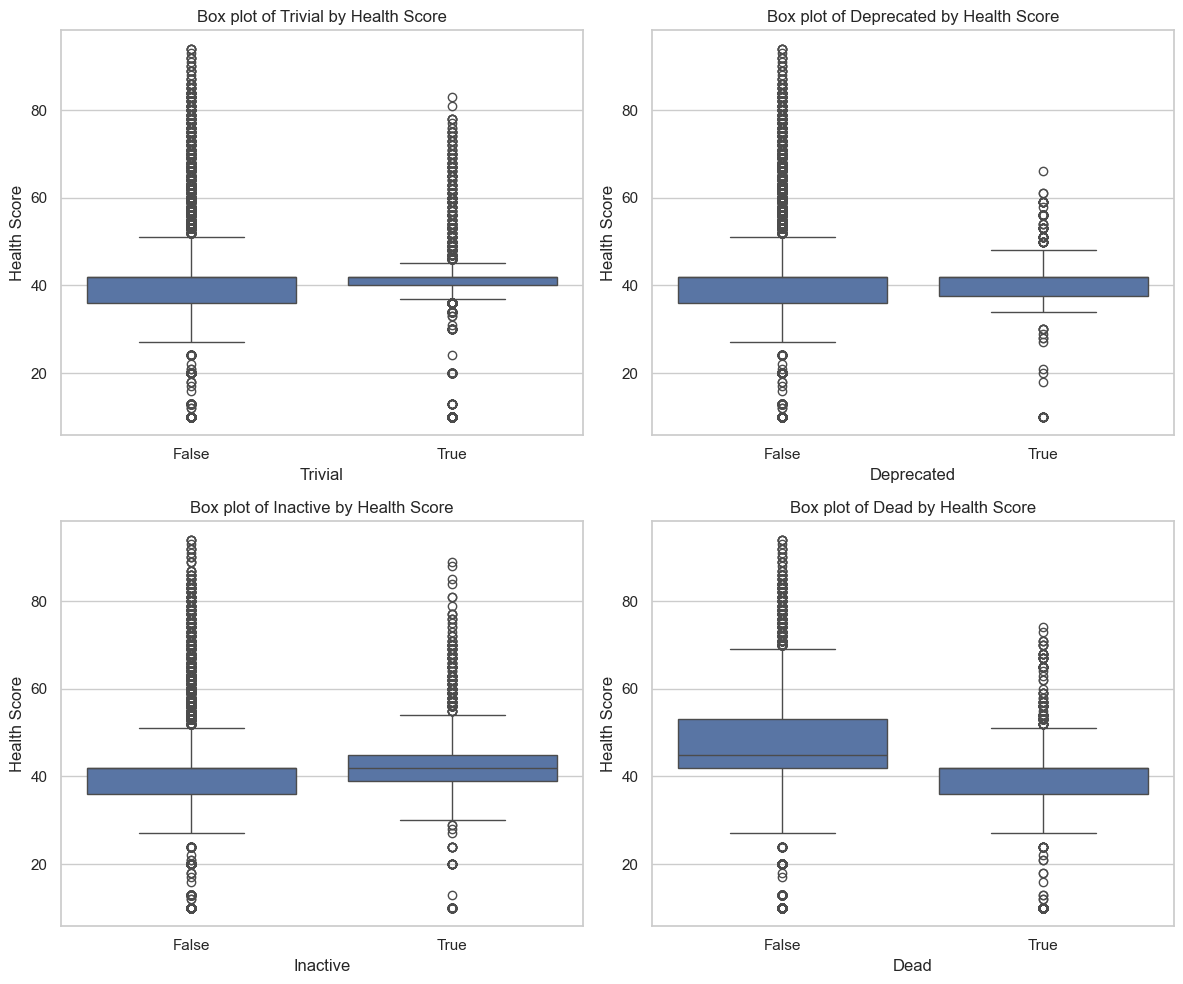

In [333]:
# Assuming post_df contains data for 'Trivial', 'Deprecated', 'Inactive', 'Dead'

# Create a f`igure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate over each category and create a box plot
categories = ['Trivial', 'Deprecated', 'Inactive', 'Dead']
for i, category in enumerate(categories):
    # Filter out NaN values
    category_data = post_df.dropna(subset=[category])
    sns.boxplot(x=category, y='Health_score', data=category_data, ax=axes[i])
    axes[i].set_title(f'Box plot of {category} by Health Score')
    axes[i].set_xlabel(category)
    axes[i].set_ylabel('Health Score')

# Adjust layout
plt.tight_layout()

plt.show()


In [334]:
health_predictors = {}


for cat in categories:
    unhealthy_df = post_df[post_df['health_status'] == 'Unhealthy']
    y = unhealthy_df[cat]
    unhealthy_df = unhealthy_df.iloc[:, :-5]
    unhealthy_df[cat] = y
    bootstrapped_samples = [unhealthy_df.sample(n=len(unhealthy_df), replace=True) for _ in range(10)]
    sustained_predictors, corr_cal = pred_corr(bootstrapped_samples, cat)
    final_predictors = package_pred(corr_cal, sustained_predictors)
    health_predictors[cat] = final_predictors
    filtered_correlation_data = [{key: value} for item in final_predictors for key, value in item.items() if abs(value) > 0.2]
    if len(filtered_correlation_data) > 0:
        health_predictors[cat] = filtered_correlation_data 
    else:
        health_predictors[cat] = [{key: value} for item in final_predictors for key, value in item.items() if abs(value) > 0.1]

In [335]:
for health_pred in health_predictors:
    print("======================================")
    print(f"{health_pred} ---> {health_corr[health_pred]}")
    print("-----------------------------------------")
    for dictionary in health_predictors[health_pred]:
        for key, value in dictionary.items():
            print(f"{key} : {value}")

Trivial ---> 29.855205699839114
-----------------------------------------
dependencies_count : -0.22408936874285784
LOC : -0.4505107912576574
total_lines_added : -0.2504829823242566
total_lines_deleted : -0.24338034000966022
SLOC_JS : -0.5319019878966805
CC : -0.4679759937742137
Deprecated ---> 30.182599355531686
-----------------------------------------
Inactive ---> 31.061164333087692
-----------------------------------------
github_stars : 0.11715499876440569
Dead ---> 39.0064397424103
-----------------------------------------
package_age_months : 0.5251323635489035
months_since_latest_version_release : 0.5883664533296843
last_commit_before_months : 0.6374084051594061
total_lines_added : -0.222227955328351
lines_added_one_and_half_year : -0.6272583378258492
lines_deleted_one_and_half_year : -0.6044460463299522
SLOC_TS : -0.3116759574047414
package_install_size : -0.3821343690932891
#_of_files : -0.38872337201961127
Security_recommendation : 0.2503516680580357
readme_updated_last_1.5

/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_25680/2801245523.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=category, y='Health_score', data=post_df.groupby(category)['Health_score'].median().reset_index(), color='black', markers='o', scale=0.7, ax=axes[row, col])
/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_25680/2801245523.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=category, y='Health_score', data=post_df.groupby(category)['Health_score'].median().reset_index(), color='black', markers='o', scale=0.7, ax=axes[row, col])
/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_2

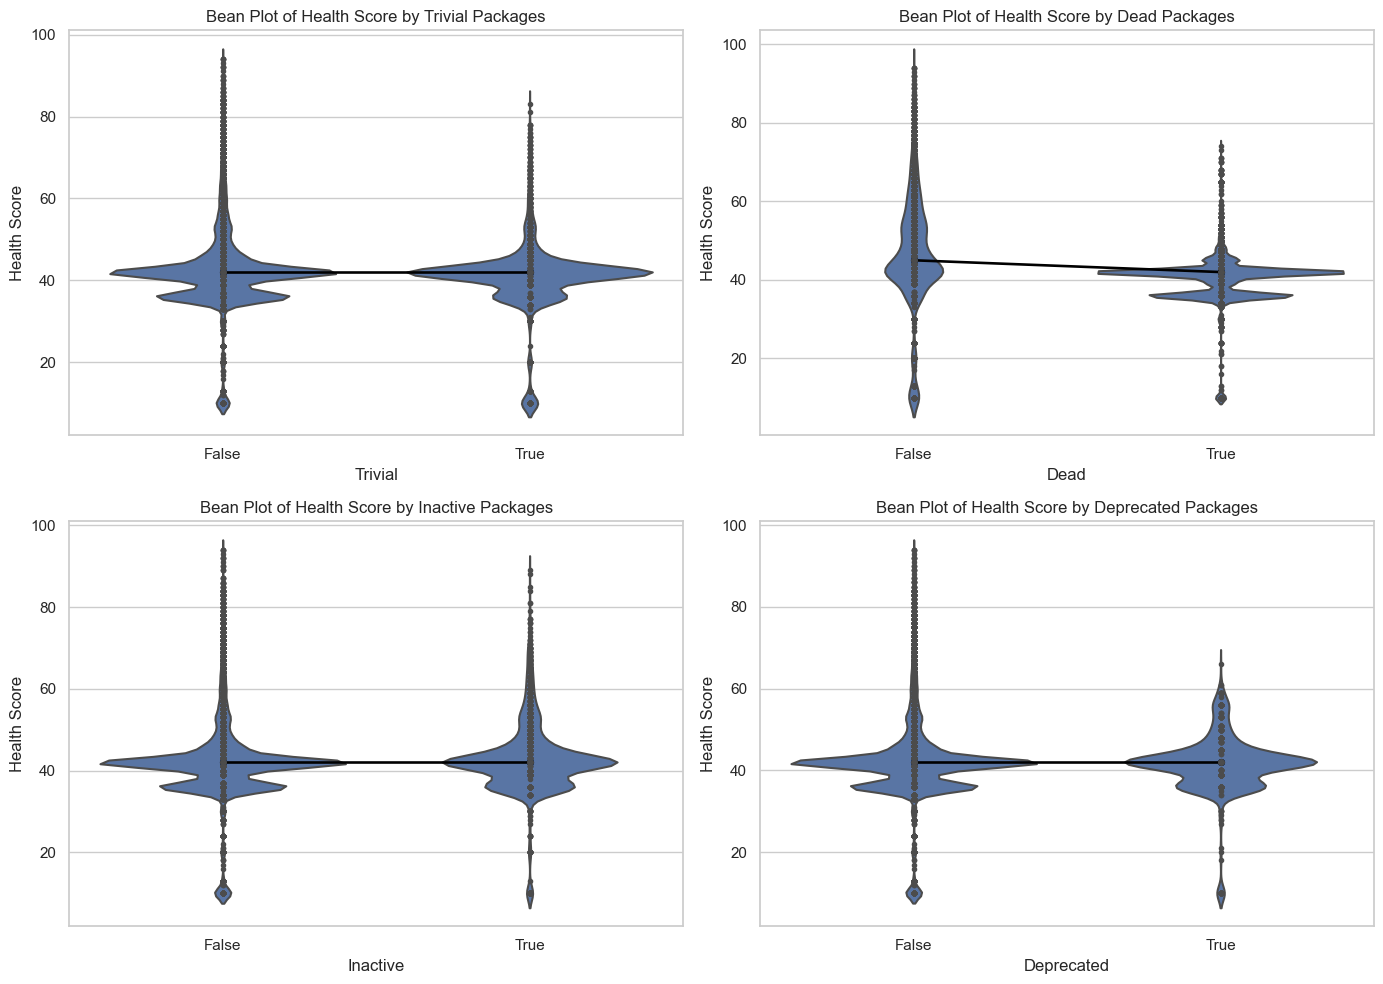

In [336]:
# Plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define categories
categories = ['Trivial', 'Dead', 'Inactive', 'Deprecated']

# Loop through each category and create bean plots
for i, category in enumerate(categories):
    row = i // 2
    col = i % 2
    
    sns.violinplot(x=category, y='Health_score', data=post_df, inner='point', linewidth=1.5, ax=axes[row, col])
    
    # Adding median values as points
    sns.pointplot(x=category, y='Health_score', data=post_df.groupby(category)['Health_score'].median().reset_index(), color='black', markers='o', scale=0.7, ax=axes[row, col])

    axes[row, col].set_title(f'Bean Plot of Health Score by {category} Packages')
    axes[row, col].set_xlabel(category)
    axes[row, col].set_ylabel('Health Score')

plt.tight_layout()
plt.show()


### Visualizations:

In [337]:
print(percentage_df.iloc[-1].tolist())

[16.003370817496634, 73.60059920818918, 9.678638941398866, 3.395869743553162]


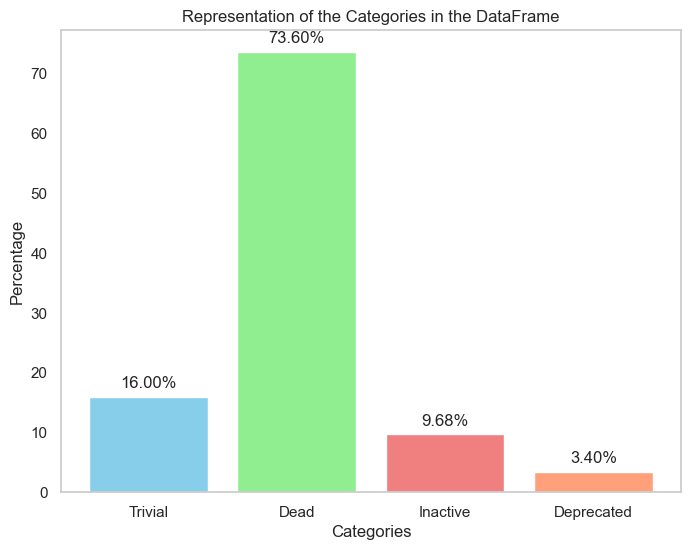

In [338]:
# Categories
categories = ['Trivial', 'Dead', 'Inactive', 'Deprecated']

# Percentages for each category
percentages = percentage_df.iloc[-1].tolist()  # Example percentages, make sure they sum up to 100

# Define colors for each category
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

# Plotting the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=colors)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Representation of the Categories in the DataFrame')

# Adding percentages on top of the bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 1, 
             f'{percentage:.2f}%',  # Formatting to two decimal places
             ha='center', 
             va='bottom')

# Set plain background
plt.gca().set_facecolor('white')

# Remove grid lines
plt.grid(False)

# Displaying the plot
plt.show()


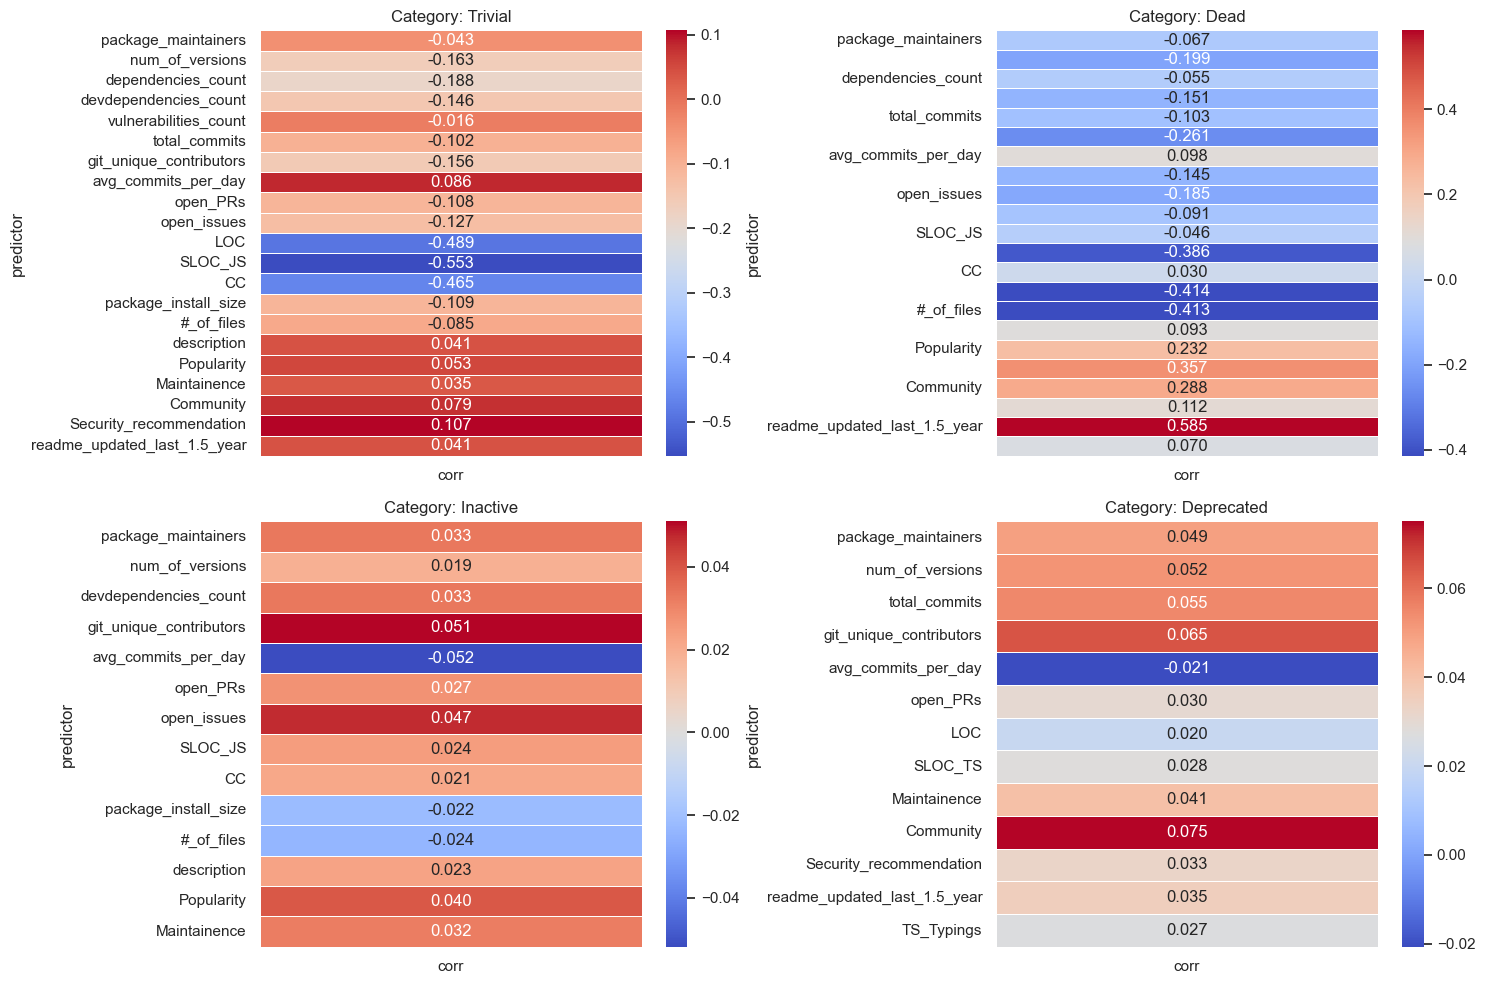

In [339]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


df1 = trivial_df
df2 = dead_df
df3 = inactive_df
df4 = deprecated_df

# Create correlation matrices
corr_matrix1 = df1.set_index('predictor')['corr'].to_frame()
corr_matrix2 = df2.set_index('predictor')['corr'].to_frame()
corr_matrix3 = df3.set_index('predictor')['corr'].to_frame()
corr_matrix4 = df4.set_index('predictor')['corr'].to_frame()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot heatmap for category 1
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, ax=axs[0, 0])
axs[0, 0].set_title('Category: Trivial')

# Plot heatmap for category 2
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, ax=axs[0, 1])
axs[0, 1].set_title('Category: Dead')

# Plot heatmap for category 3
sns.heatmap(corr_matrix3, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, ax=axs[1, 0])
axs[1, 0].set_title('Category: Inactive')

# Plot heatmap for category 4
sns.heatmap(corr_matrix4, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, ax=axs[1, 1])
axs[1, 1].set_title('Category: Deprecated')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [340]:
list(pair_corr.keys())

[('Trivial', 'Dead'),
 ('Trivial', 'Deprecated'),
 ('Trivial', 'Inactive'),
 ('Dead', 'Deprecated'),
 ('Dead', 'Inactive'),
 ('Deprecated', 'Inactive'),
 ('Dead', 'Trivial'),
 ('Deprecated', 'Trivial'),
 ('Inactive', 'Trivial'),
 ('Deprecated', 'Dead'),
 ('Inactive', 'Dead'),
 ('Inactive', 'Deprecated')]

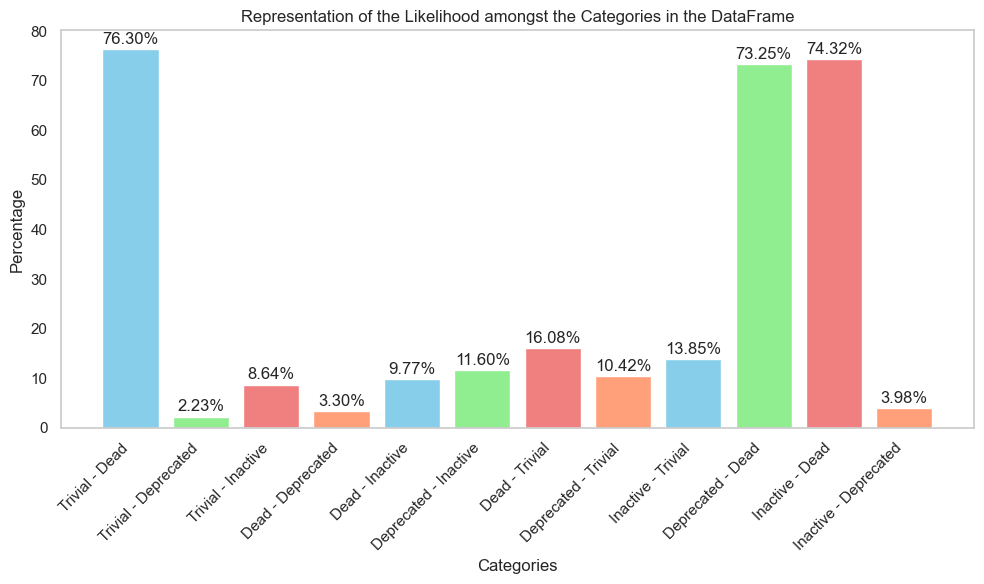

In [341]:
import matplotlib.pyplot as plt

# Extracting categories and converting tuples into unique category names
categories = [' - '.join(category) for category in list(pair_corr.keys())]

# Extracting values from the dictionary
percentages = list(pair_corr.values())  # Example percentages, make sure they sum up to 100

# Define colors for each category
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, percentages, color=colors)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Representation of the Likelihood amongst the Categories in the DataFrame')

# Adding percentages on top of the bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 0.5, 
             f'{percentage:.2f}%',  # Formatting to two decimal places
             ha='center', 
             va='bottom')

# Set plain background
plt.gca().set_facecolor('white')

# Remove grid lines
plt.grid(False)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.tight_layout()
plt.show()


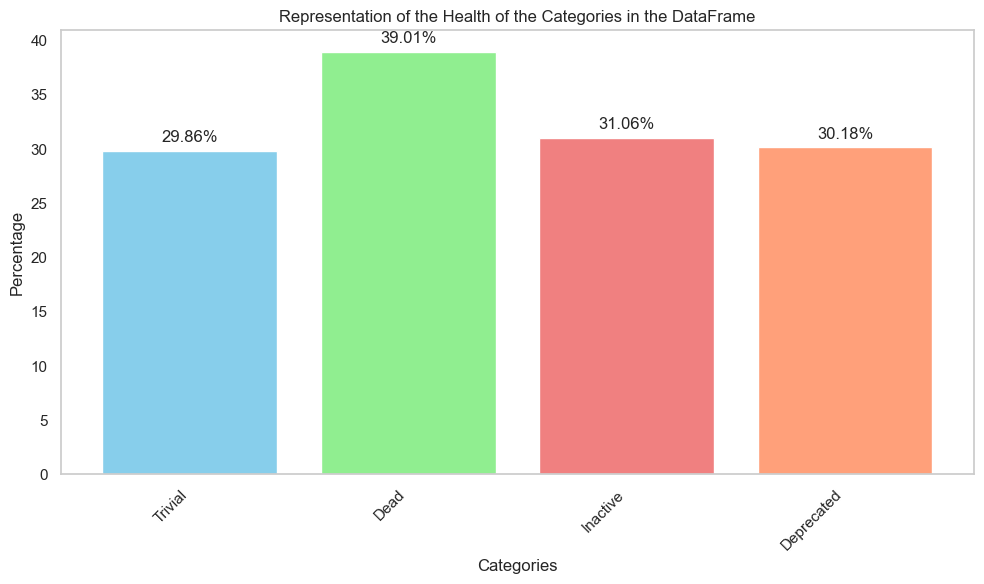

In [342]:
import matplotlib.pyplot as plt

# Extracting categories and converting tuples into unique category names
categories = list(health_corr.keys())

# Extracting values from the dictionary
percentages = list(health_corr.values())  # Example percentages, make sure they sum up to 100

# Define colors for each category
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, percentages, color=colors)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Representation of the Health of the Categories in the DataFrame')

# Adding percentages on top of the bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 0.5, 
             f'{percentage:.2f}%',  # Formatting to two decimal places
             ha='center', 
             va='bottom')

# Set plain background
plt.gca().set_facecolor('white')

# Remove grid lines
plt.grid(False)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.tight_layout()
plt.show()


In [343]:
def create_df(data):
    predictors = []
    correlations = []
    for item in data:
        for key, value in item.items():
            predictors.append(key)
            correlations.append(value)
    
    # Create DataFrame
    final_df = pd.DataFrame({'predictor': predictors, 'corr': correlations})
    return final_df

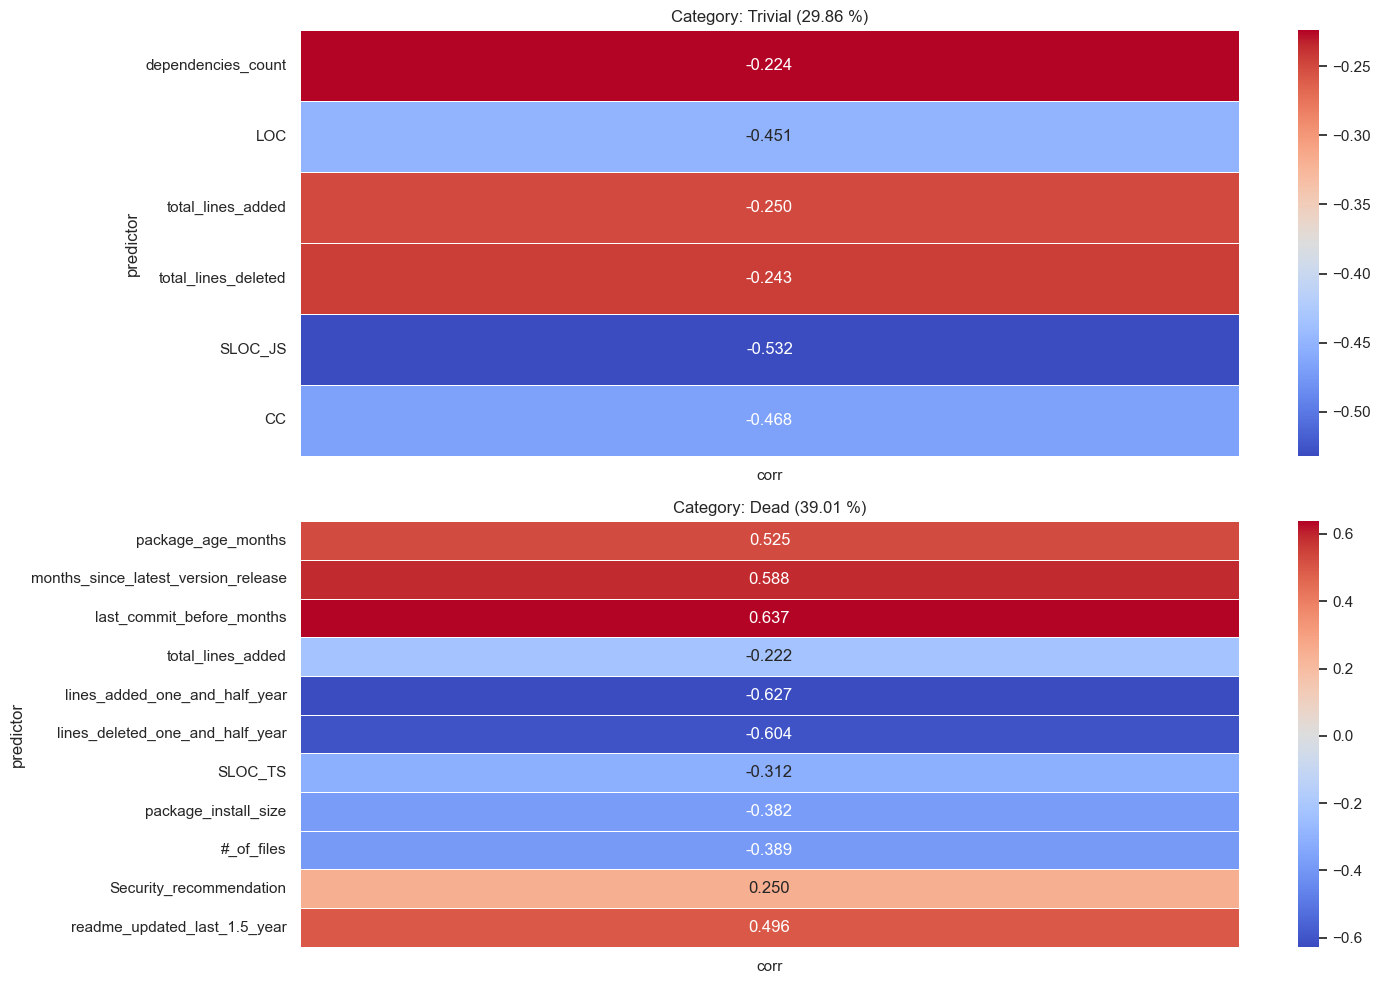

In [348]:
df1 = create_df(health_predictors['Trivial'])
df2 = create_df(health_predictors['Dead'])
df3 = create_df(health_predictors['Inactive'])
df4 = create_df(health_predictors['Deprecated'])

# Create correlation matrices
corr_matrix1 = df1.set_index('predictor')['corr'].to_frame()
corr_matrix2 = df2.set_index('predictor')['corr'].to_frame()
corr_matrix3 = df3.set_index('predictor')['corr'].to_frame()
corr_matrix4 = df4.set_index('predictor')['corr'].to_frame()

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot heatmap for category 1
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, ax=axs[0])
axs[0].set_title(f'Category: Trivial ({health_corr["Trivial"]:.2f} %)')

# Plot heatmap for category 2
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, ax=axs[1])
axs[1].set_title(f'Category: Dead ({health_corr["Dead"]:.2f} %)')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
